In [4]:
import hyperSLIC # Note dont have centroids respawn after being orphaned
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing as mp
import numba as nb
from numba import jit,prange,njit
from tqdm import tqdm
import os
import copy
import glob
%matplotlib qt5

In [33]:
s = hs.load(r"D:\Dropbox (Cambridge University)\tas72@cam.ac.uk’s_files\Data_Backup\mg32809\SED\Rice_1_1\20230426_122340\apply_cal_to_sed_data.800398\apply_cal_to_sed_data\20230426_122340_calibrated_data_bin2.hspy",lazy=True)
s = s.inav[:,:]
#s = s.rebin(scale=[1,1,2,2])
s.data = s.data.astype('float32')
s.compute()

[########################################] | 100% Completed |  2min 34.2s


In [16]:
constant = 15

In [17]:
s.isig[(s.axes_manager[2].size//2)-constant:(s.axes_manager[2].size//2)+constant,(s.axes_manager[3].size//2)-constant:(s.axes_manager[3].size//2)+constant] = 0#np.zeros((constant*2,constant*2))

In [18]:
s.plot(vmax=10)

In [19]:
@jit(nopython=True)
def normalise(channel):
    channel = (channel - np.amin(channel))+1 # breaks if value of 0 is given
    channel = channel/np.amax(channel)
    return channel


def plot_ranges(raveled,percentile,bins, mode, plot_or_not):
    reshaped = np.reshape(raveled, (np.shape(raveled)[0]*np.shape(raveled)[1], np.shape(raveled)[2]))
    if mode == 'range':
        ranges = np.ptp(reshaped, axis=0)
    if mode == 'var':
        ranges = np.var(reshaped,axis=0)
    percentile = np.percentile(ranges,percentile)
    print(percentile)
    if plot_or_not == True:
        fig,ax = plt.subplots()
        ax.hist(ranges,density = True, bins = bins)
        plt.yscale('log')

        ax.axvline(percentile,linestyle = ":",color ='r' )

@jit(nopython = True)
def quick_wheat(ranges, reshaped, percentile):
    wheat = reshaped.T[ranges >= percentile]
    return wheat.T

def wheat_from_chaff(data, percentile,mode):
    reshaped = np.reshape(data, (np.shape(data)[0]*np.shape(data)[1], np.shape(data)[2]))
    print(np.shape(reshaped))
    print('Reshaped')
    if mode == 'range':
        ranges = np.ptp(reshaped, axis=0)
    if mode == 'var':
        ranges = np.var(reshaped,axis=0)
    ranges = np.ptp(reshaped, axis=0)
    print(np.shape(ranges))
    print('Ranges aquried')
    percentile = np.percentile(ranges,percentile)
    print(percentile)
    wheat = quick_wheat(ranges, reshaped, percentile)
    print(np.shape(wheat))
    print('Wheat seperated')
    maxes = np.amax(wheat, axis=0)
    minis = np.amin(wheat,axis=0) 
    
    wheat = wheat - minis

    wheat = wheat/maxes
    
    wheat = np.reshape(wheat,(np.shape(data)[0],np.shape(data)[1],-1))
    return wheat

In [20]:
raveled = np.reshape(s.data, (s.axes_manager[1].size, s.axes_manager[0].size,s.axes_manager[2].size*s.axes_manager[3].size))

In [21]:
plot_ranges(raveled,98,50,'range',True)

17.16569610595702


In [58]:
wheat = wheat_from_chaff(raveled,95,'range')
print('Complete', np.shape(wheat))

(16129, 265225)
Reshaped
(265225,)
Ranges aquried
9.310580444335928
(16129, 13262)
Wheat seperated
Complete (127, 127, 13262)


In [59]:
wheat_hs = hs.signals.Signal1D(wheat)

In [60]:
wheat_hs.T.plot()

In [62]:
test = hyperSLIC.SLIC(wheat_hs,'regular',300,1,1) # seed_num, m, searchspace

In [63]:
t0 = time.time()
for i in tqdm(range(20)):
    
    test.find_closest_centeroid()
    test.update_centeroids()
t1 = time.time()
print(f'Time: {np.round((t1-t0),3)}s')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:48<00:00,  2.40s/it]

Time: 48.039s


In [64]:
vals = np.linspace(0,1,256)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_stern(vals))
np.random.shuffle(vals)
centeroids = np.zeros((test.width,test.height))
for counter,centeroid in enumerate(test.xy_centeroids):
    centeroids[int(centeroid[0]),int(centeroid[1])] = counter    
fig,ax = plt.subplots()
ax.imshow(centeroids,vmax=0.1,cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])

[]

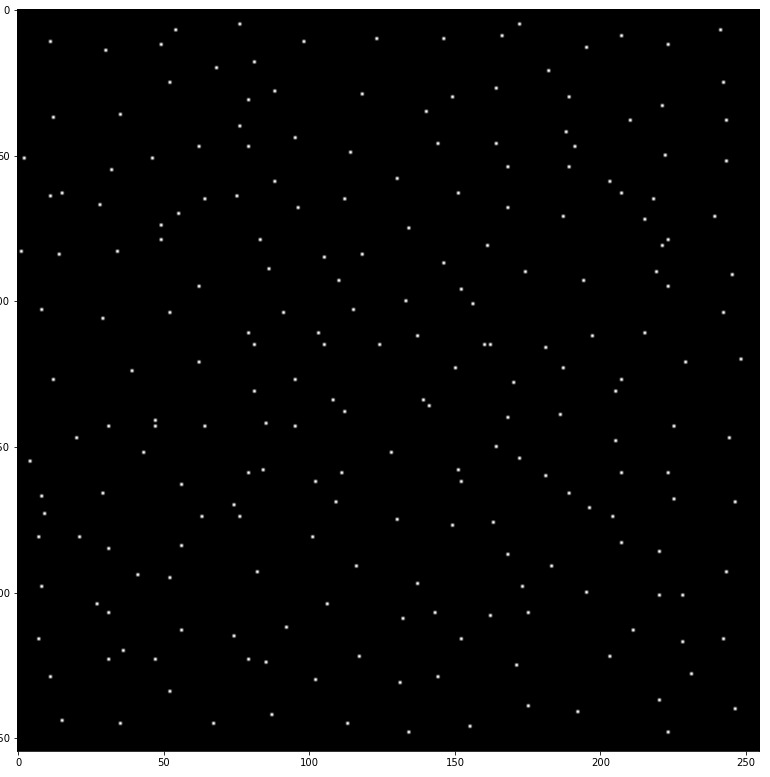

In [46]:
summed = s.T.sum().data

In [65]:
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_stern(vals))

fig,ax = plt.subplots(1,3)
ax[0].imshow(summed,cmap='gray')
ax[1].imshow(test.closest_centeroid,cmap=cmap)
ax[2].imshow(summed,cmap='gray')
ax[2].imshow(test.closest_centeroid,cmap=cmap,alpha=0.25)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
#plt.savefig('dark_feild_total',dpi=600)

[]

Check if regions are similar to eachother- and merge is this is so

In [66]:
summed_channels = np.zeros(test.k,dtype='object')
number_of_occurances = np.zeros(test.k)

for row in tqdm(range(np.shape(test.closest_centeroid)[0])):
    for col in range(np.shape(test.closest_centeroid)[1]):
        
        arg = int(test.closest_centeroid[row,col])
        number_of_occurances[arg] += 1 
        channel = test.dot_data[row,col].astype(np.float32)# Use the copy not the data with the masked bright feild
        summed_channels[arg]+=channel

for i in range(len(number_of_occurances)):
    occurances = number_of_occurances[i]
    if occurances == 0:
        number_of_occurances[i] = np.nan
        

mean_channels = summed_channels/number_of_occurances


100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 77.91it/s]


In [71]:
from scipy.stats.stats import pearsonr
updated_centroids = copy.deepcopy(test.closest_centeroid)
for i in tqdm(range(len(mean_channels))):
    channel_oi = mean_channels[i]
    for counter,comparison_channel in enumerate(mean_channels[i:]):
        
        try:
            r = pearsonr(channel_oi,comparison_channel)
            if r[0] > 0.9:
                args = np.where(updated_centroids == i)
                for j in range(len(args[0])):
                        row = args[0][j]
                        col = args[1][j]
                        updated_centroids[row,col] = i+counter
        except:
            pass

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 91.21it/s]


In [72]:
fig,ax = plt.subplots(1,4)
ax[0].imshow(summed,cmap='gray')
ax[1].imshow(test.closest_centeroid,cmap=cmap)
ax[2].imshow(updated_centroids,cmap=cmap)
ax[3].imshow(summed,cmap='gray')
ax[3].imshow(updated_centroids,cmap=cmap,alpha=0.25)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_xticks([])
ax[3].set_yticks([])
#plt.savefig('mereged.png', dpi=800)

[]

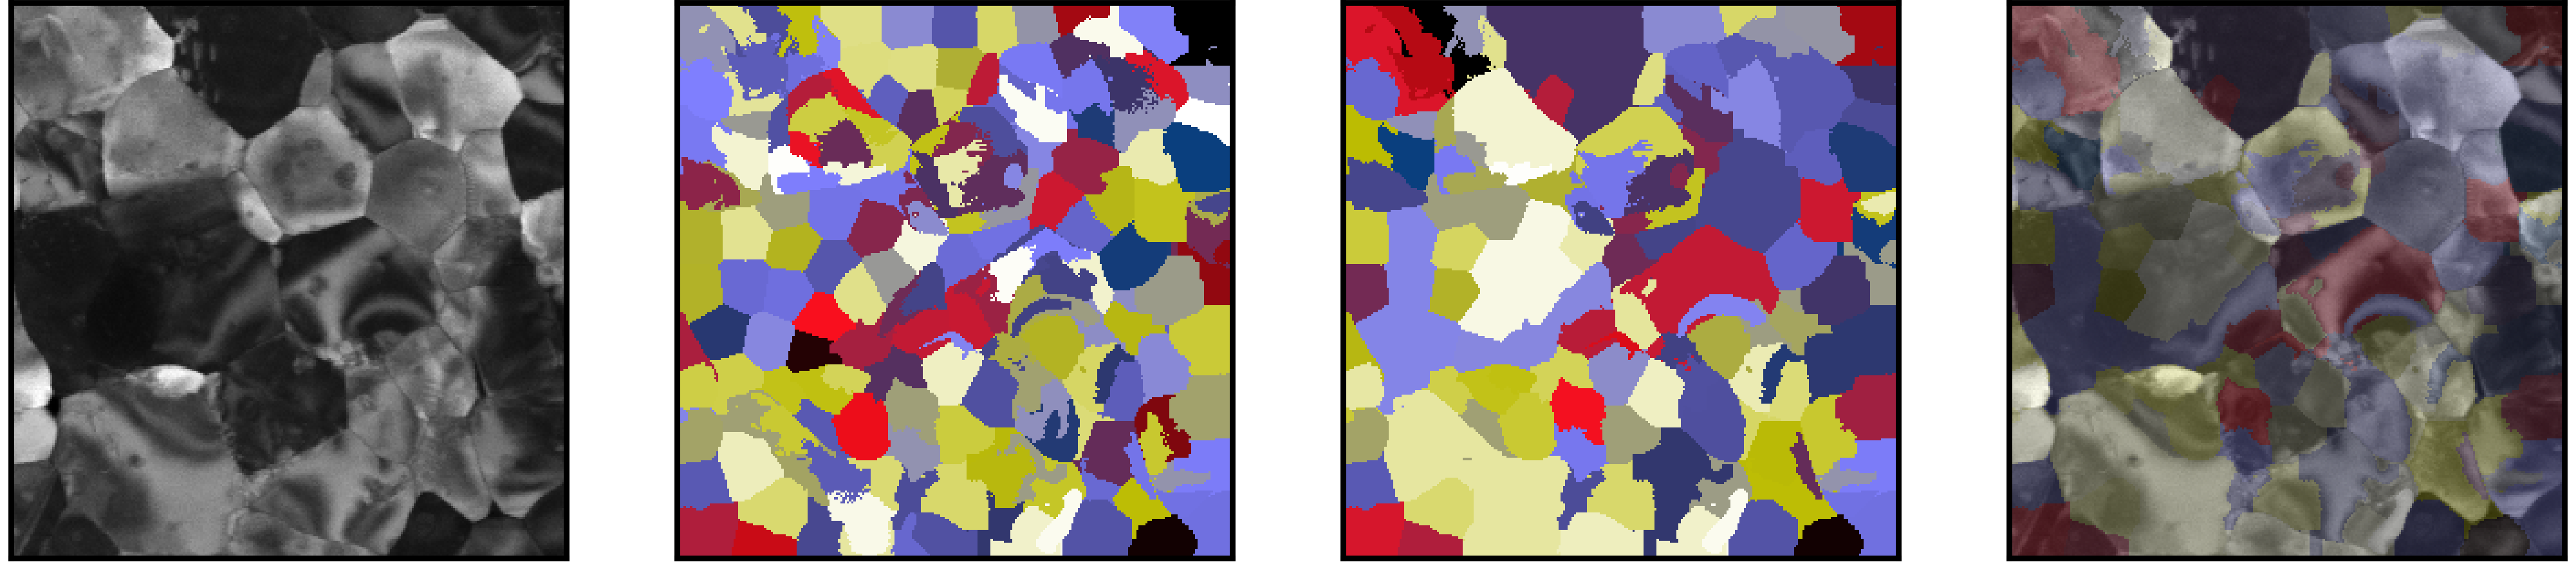

In [73]:
s = hs.load(r"D:\Dropbox (Cambridge University)\tas72@cam.ac.uk’s_files\Data_Backup\mg32809\SED\Rice_1_1\20230426_122340\apply_cal_to_sed_data.800398\apply_cal_to_sed_data\20230426_122340_calibrated_data_bin2.hspy",lazy=True)
s = s.inav[:,:]
#s = s.rebin(scale=[1,1,2,2])
s.data = s.data.astype('float32')
s.compute()

[########################################] | 100% Completed |  2min 36.2s


In [75]:
summed_patterns = np.zeros((test.k,np.shape(s.inav[0,0].data)[0],np.shape(s.inav[0,0].data)[1]),dtype = 'float32')

number_of_occurances = np.zeros(test.k)


for row in tqdm(range(np.shape(test.closest_centeroid)[0])):
    for col in range(np.shape(test.closest_centeroid)[1]):
        
        arg = int(updated_centroids[row,col])
        number_of_occurances[arg] += 1 
        pattern = s.data[row,col].astype(np.float32)# Use the copy not the data with the masked bright feild
        summed_patterns[arg]+=pattern


        


mean_patterns = np.zeros_like(summed_patterns)
for i in tqdm(range(len(mean_patterns))):
    occurances = number_of_occurances[i]
    if occurances == 0:
        mean_patterns[i] = np.zeros((515,515))
    else:
        mean_patterns[i] = summed_patterns[i]/number_of_occurances[i]

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 2578.50it/s]


In [78]:
for pattern in mean_patterns:
    fig,ax = plt.subplots()
    ax.imshow(pattern,cmap='Greys')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.waitforbuttonpress()
    plt.close()

In [81]:
fig,ax = plt.subplots(10,30)
for i in range(10):
    for j in range(30):
        try:
            ax[i,j].imshow(mean_patterns[i*30+j],vmax=2,cmap='Greys')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].title.set_text(i*30+j)

        except:
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

plt.tight_layout()
plt.subplots_adjust(left=0, right=1, top=1, bottom=0,wspace=-0, hspace=0)
#plt.savefig('all_patterns.png', dpi=300)

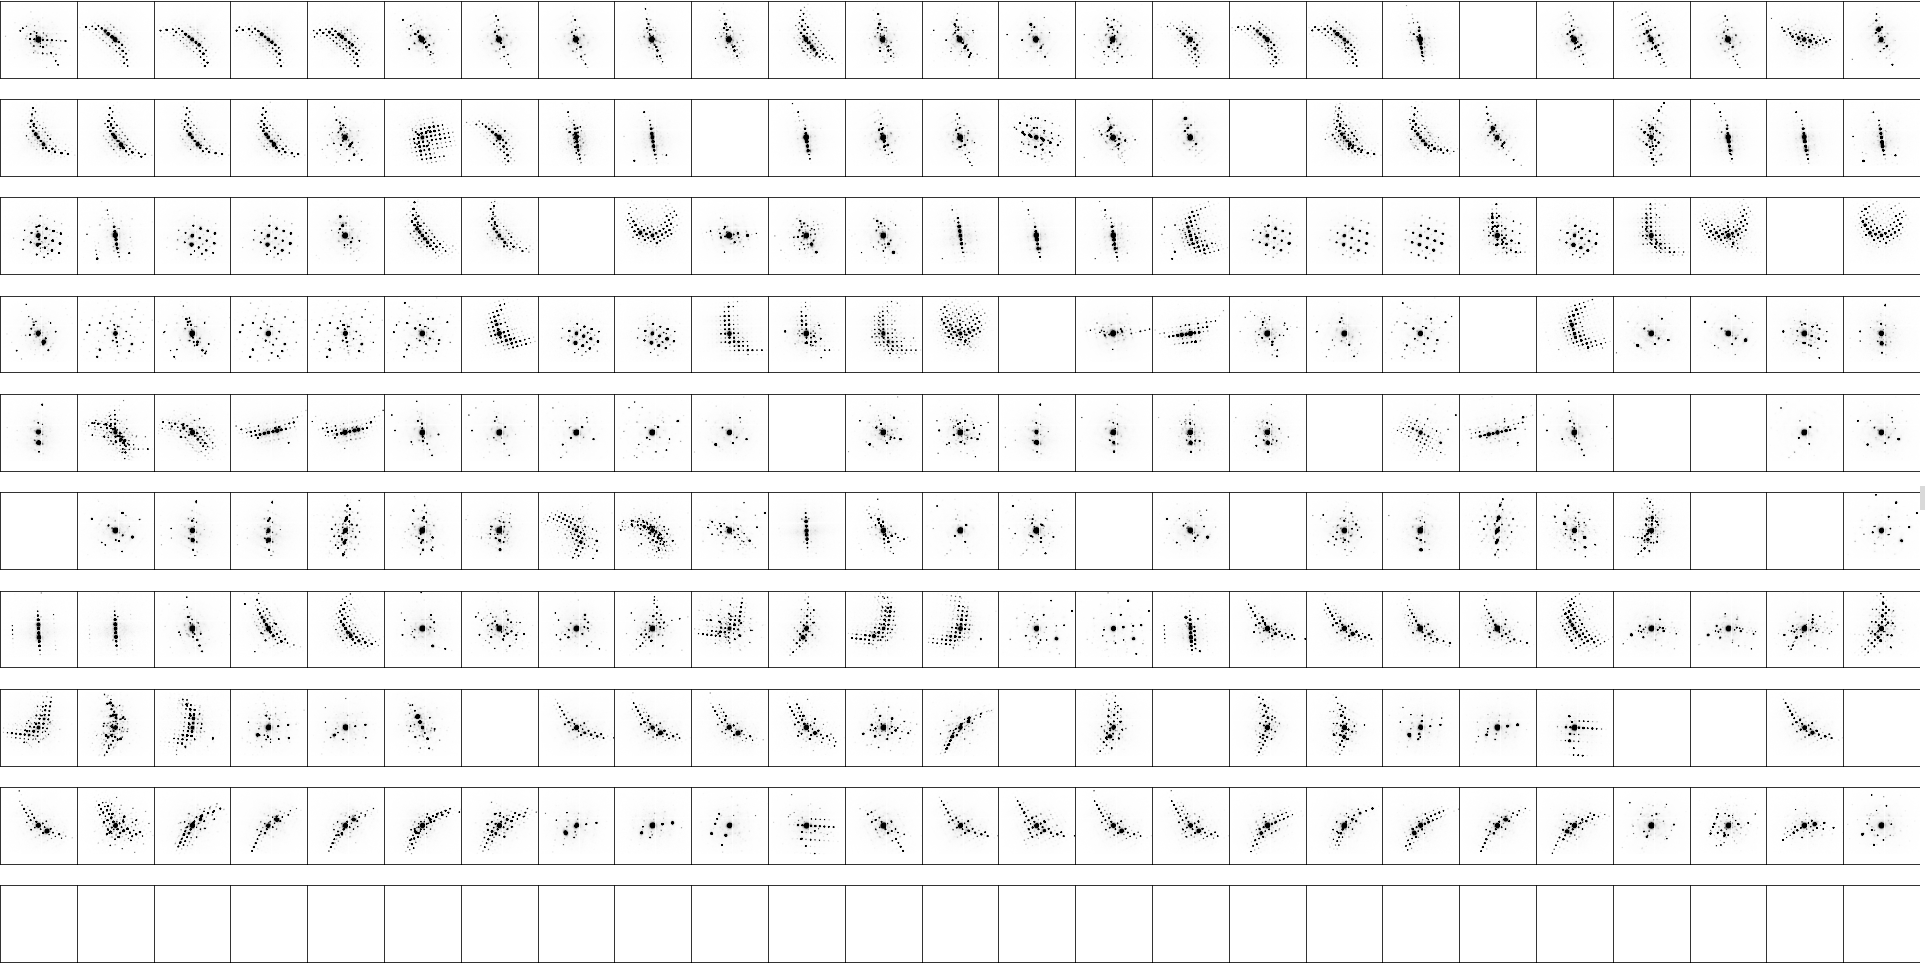

In [63]:
np.shape(mean_patterns)

(700, 256, 256)

In [64]:
updated_centroids

array([[  0.,   0.,   0., ...,  25.,   0.,   0.],
       [  0.,   0.,   0., ...,  25.,   0.,   0.],
       [  0.,   0.,   0., ...,  25.,   0.,   0.],
       ...,
       [650., 650., 650., ..., 675., 675., 675.],
       [650., 650., 650., ..., 675., 675., 675.],
       [650., 650., 650., ..., 675., 675., 675.]])

In [23]:
np.save('diffrcation_patterns_chcl_105658',mean_patterns)

In [24]:
np.save('clusters_chcl_105658',updated_centroids)

# Go to ACOM notebook then get phase and confidence map

In [8]:
confidence = np.load('confidence.npy')
phase_map = np.load('phase_map.npy')

In [9]:
summed = s.T.sum().data
summed = summed.compute()

AttributeError: 'numpy.ndarray' object has no attribute 'compute'

In [18]:

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.patches import Rectangle

fig = plt.figure()
grid = ImageGrid(fig, 111,
                nrows_ncols = (1,3),
                axes_pad = 0.05,
                cbar_location = "right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )
grid[0].imshow(summed,cmap='gray')
grid[1].imshow(summed,cmap='gray')

grid[1].imshow(phase_map,cmap='bwr',alpha=0.2)


conf = grid[2].imshow(confidence,cmap='plasma',vmax=0.1)
grid[0].set_xticks([])
grid[1].set_xticks([])
grid[2].set_xticks([])
grid[0].set_yticks([])
grid[1].set_yticks([])
grid[2].set_yticks([])
plt.colorbar(conf, cax=grid.cbar_axes[0])
grid[0].add_patch(Rectangle((10, 230), 300e-9/real_space, 5,facecolor = 'w'))
#plt.savefig('phase_map.png',dpi=600)

In [90]:
os.getcwd()

'C:\\Users\\tas72\\Documents\\PhD\\SLIC_clustering'

In [65]:
s.plot(vmax=1)

In [16]:
s.inav[108:134,169:200].mean().plot(vmax=0.1)

In [23]:
s.inav[118:127,193:203].mean().plot(vmax=0.4)

Nice perovskite patterns

In [35]:
s.inav[175:197,74:99].mean().plot(vmax=0.2,cmap='Greys')

In [32]:
s.inav[36:82,191:245].mean().plot(vmax=0.2,cmap='Greys')

In [31]:
s.inav[12:44,5:32].mean().plot(vmax=0.2,cmap='Greys')

In [38]:
s.inav[182:210,163:182].mean().plot(vmax=0.2,cmap='Greys')

In [67]:
s.plot()

In [45]:
fig,ax = plt.subplots()
ax.imshow(summed,'gray')
ax.set_yticks([])
ax.set_xticks([])
ax.add_patch(Rectangle((10, 230), 300e-9/real_space, 5,facecolor = 'w'))
plt.savefig('summed.png',dpi=600)

In [56]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(s.inav[108:134,169:200].mean().data,vmax=0.1,cmap='Greys')
ax[1].imshow(s.inav[118:127,193:203].mean().data,vmax=0.4, cmap = 'Greys')
ax[0].add_patch(Rectangle((25,470),1/0.005345723405676194,10,facecolor = 'black'))
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
plt.savefig('pbi2_patterns.png',dpi = 600)

In [66]:
fig,ax = plt.subplots(1,2)
ax[1].imshow(s.inav[175:197,74:99].mean().data,vmax=0.2,cmap='Greys')
ax[0].imshow(s.inav[12:44,5:32].mean().data,vmax=0.2,cmap='Greys')
ax[0].add_patch(Rectangle((25,470),1/0.005345723405676194,10,facecolor = 'black'))
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
plt.savefig('perovskite_patterns1.png',dpi = 600)

In [64]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(s.inav[36:82,191:245].mean().data,vmax=0.2,cmap='Greys')
ax[1].imshow(s.inav[182:210,163:182].mean().data,vmax=0.2,cmap='Greys')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
plt.savefig('perovskite_patterns2.png',dpi = 600)